In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [64]:
def plot_uncertainty(ax, xdist, xs, vdist=None, x_max=None):
    """Plot the uncertainty in position and velocity"""
    probs = xdist.pdf(xs)
    ax.plot(probs, xs)
    right_lim = x_max if x_max is not None else probs.max()*1.5
    ax.set_xlim(right=right_lim)
    ax.set_xticks(())
    ax.set_yticks(())
    if vdist is not None:
        anchor = (0, xdist.mean())
        end_y = vdist.mean() + xdist.mean()
        ax.annotate("", xy=(right_lim, end_y), xytext=anchor, arrowprops=dict(
            arrowstyle="->",
        ))
        ax.annotate("", xy=(right_lim, end_y - vdist.std()), xytext=anchor, arrowprops=dict(
            arrowstyle="->", ec=(.3, .3, .3)
        ))
        ax.annotate("", xy=(right_lim, end_y + vdist.std()), xytext=anchor, arrowprops=dict(
            arrowstyle="->", ec=(.3, .3, .3)
        ))
        ax.annotate("", xy=(right_lim, end_y - 2 * vdist.std()), xytext=anchor, arrowprops=dict(
            arrowstyle="->", ec=(.6, .6, .6)
        ))
        ax.annotate("", xy=(right_lim, end_y + 2 * vdist.std()), xytext=anchor, arrowprops=dict(
            arrowstyle="->", ec=(.6, .6, .6)
        ))
        ax.annotate("", xy=(right_lim, end_y - 3 * vdist.std()), xytext=anchor, arrowprops=dict(
            arrowstyle="->", ec=(.9, .9, .9)
        ))
        ax.annotate("", xy=(right_lim, end_y + 3 * vdist.std()), xytext=anchor, arrowprops=dict(
            arrowstyle="->", ec=(.9, .9, .9)
        ))
    return right_lim


def marginalize_normal(p, ind):
    return sp.stats.norm(
        loc=p.mean[ind],
        scale=np.sqrt(p.cov[ind,ind])
    )


In [54]:
# System Parameters
x0 = np.array([[1.5, 0]]).T
dt = 1
P0 = 1/4 * np.array([[5, 4], [4, 5]])
Q = 6/10 * np.array([[dt, dt**2/2], [dt**2/2, dt**3/3]])
F = np.array([[1, 0], [dt, 1]])
R = np.array([[.3]])
H = np.array([[0, 1]])
z = np.array([.5])

In [26]:
P = F @ P0 @ F.T + Q
S = H @ P @ H.T + R
K = P @ H.T @ np.linalg.inv(S)
x_p = F @ x0
y = z - H @ x_p
x_pp = x_p + K @ y
P_p = P - K @ H @ P

In [27]:
xs = np.linspace(-3, 7, 50)
vs = np.linspace(-2, 5, 50)
v_mesh, x_mesh = np.meshgrid(vs, xs)
pos = np.dstack((v_mesh, x_mesh))
p_x0 = sp.stats.multivariate_normal(mean=x0.flatten(), cov=P0)
p_x1_x0 = sp.stats.multivariate_normal(mean=x_p.flatten(), cov=P)
p_z_x1 = sp.stats.multivariate_normal(mean=z.flatten(), cov=R)
p_x1_x1 = sp.stats.multivariate_normal(mean=x_pp.flatten(), cov=P_p)

1.8867033185563025

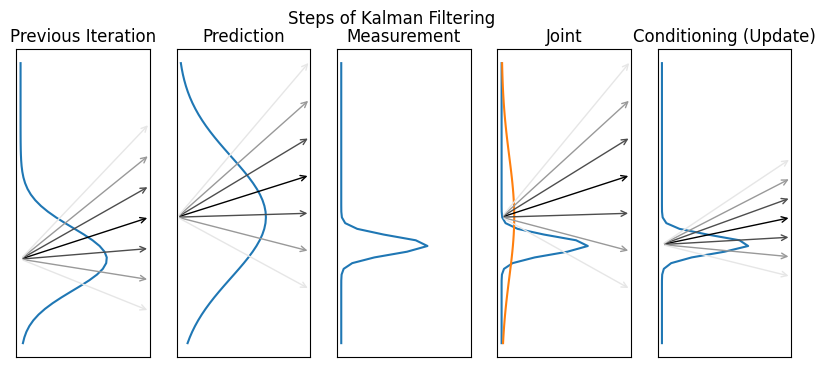

In [65]:
fig = plt.figure(figsize=[10,4])
fig.suptitle("Steps of Kalman Filtering")
ax = fig.add_subplot(1, 5, 1)
ax.set_title("Previous Iteration")
plot_uncertainty(
    ax,
    marginalize_normal(p_x0, 1),
    xs,
    marginalize_normal(p_x0, 0),
)

ax = fig.add_subplot(1, 5, 2, sharey=ax)
ax.set_title("Prediction")
plot_uncertainty(
    ax,
    marginalize_normal(p_x1_x0, 1),
    xs,
    marginalize_normal(p_x1_x0, 0),
)

ax = fig.add_subplot(1, 5, 3, sharey=ax)
ax.set_title("Measurement")
plot_uncertainty(
    ax,
    p_z_x1,
    xs,
)

ax = fig.add_subplot(1, 5, 4, sharey=ax)
ax.set_title("Joint")
x_max = plot_uncertainty(
    ax,
    p_z_x1,
    xs,
)
plot_uncertainty(
    ax,
    marginalize_normal(p_x1_x0, 1),
    xs,
    marginalize_normal(p_x1_x0, 0),
    x_max,
)

ax = fig.add_subplot(1, 5, 5, sharey=ax)
ax.set_title("Conditioning (Update)")
plot_uncertainty(
    ax,
    marginalize_normal(p_x1_x1, 1),
    xs,
    marginalize_normal(p_x1_x1, 0),
)

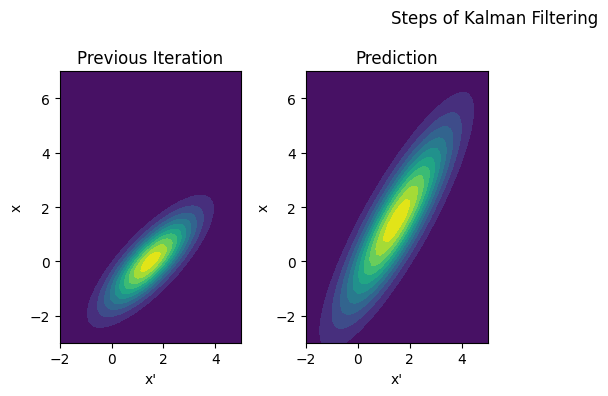

In [32]:
fig = plt.figure(figsize=[10,4])
fig.suptitle("Steps of Kalman Filtering")

# Plot 1
ax = fig.add_subplot(1, 4, 1)
ax.contourf(v_mesh, x_mesh, p_x0.pdf(pos), levels=12)
ax.set_title("Previous Iteration")
ax.set_xlabel("x'")
ax.set_ylabel("x")

# Plot 2
ax = fig.add_subplot(1, 4, 2)
ax.contourf(v_mesh, x_mesh, p_x1_x0.pdf(pos), levels=12)
ax.set_title("Prediction")
ax.set_ylabel("x")
ax.set_xlabel("x'")

fig.tight_layout()